In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


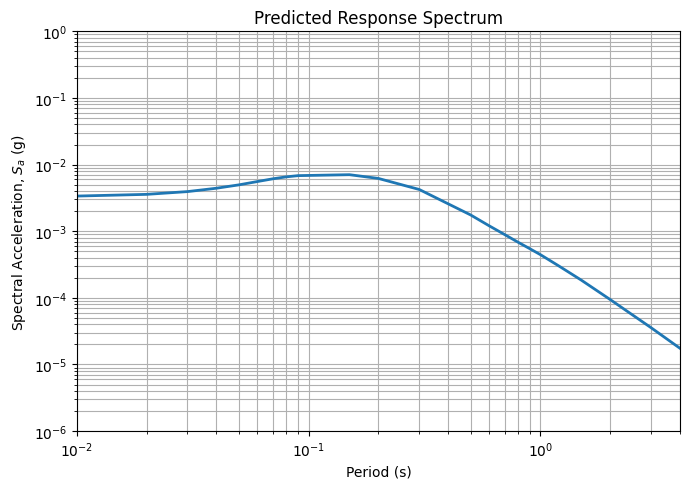

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

# -----------------------------
# Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load saved bundle (SAFE)
# -----------------------------
bundle = torch.load(
    "/content/drive/MyDrive/llm model/model/stt_gmm_weights.pt",
    map_location=device,
    weights_only=True
)

import pandas as pd

# Load input normalization stats (TRAINING TIME)
norm_in = pd.read_csv(
    "/content/drive/MyDrive/llm model/input_normalization_stats.csv"
)

mu_cont = norm_in["mean"].values
std_cont = norm_in["std"].values

assert mu_cont.shape[0] == 5
assert std_cont.shape[0] == 5


# -----------------------------
# Model definitions (INFERENCE ONLY)
# -----------------------------
class ContextEncoder(nn.Module):
    def __init__(self,
                 num_continuous=5,
                 ftype_vocab_size=5,
                 dir_vocab_size=2,
                 num_events=None,
                 cont_emb_dim=32,
                 ftype_emb_dim=8,
                 dir_emb_dim=4,
                 context_dim=64):
        super().__init__()

        self.cont_proj = nn.Sequential(
            nn.Linear(num_continuous, cont_emb_dim),
            nn.ReLU(),
            nn.Linear(cont_emb_dim, cont_emb_dim)
        )

        self.ftype_emb = nn.Embedding(ftype_vocab_size, ftype_emb_dim)
        self.dir_emb   = nn.Embedding(dir_vocab_size, dir_emb_dim)
        self.event_emb = nn.Embedding(num_events, context_dim)

        fusion_dim = cont_emb_dim + ftype_emb_dim + dir_emb_dim
        self.fusion = nn.Sequential(
            nn.Linear(fusion_dim, context_dim),
            nn.ReLU(),
            nn.Linear(context_dim, context_dim)
        )

    def forward(self, x_cont, x_ftype, x_dir, event_id):
        cont = self.cont_proj(x_cont)
        ftype = self.ftype_emb(x_ftype)
        direc = self.dir_emb(x_dir)
        fused = torch.cat([cont, ftype, direc], dim=-1)
        return self.fusion(fused) + self.event_emb(event_id)


class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            d_model, n_heads, dropout=dropout, batch_first=True
        )
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        attn, _ = self.attn(x, x, x)
        x = self.norm1(x + self.drop(attn))
        ff = self.ff(x)
        return self.norm2(x + self.drop(ff))


class SpectralTokenTransformer(nn.Module):
    def __init__(self,
                 token_dim=1,
                 context_dim=64,
                 d_model=64,
                 n_layers=4,
                 n_heads=4,
                 d_ff=256,
                 dropout=0.1):
        super().__init__()
        self.token_embed = nn.Linear(token_dim, d_model)
        self.context_proj = nn.Linear(context_dim, d_model)
        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        self.output_head = nn.Linear(d_model, 1)

    def forward(self, tokens, context):
        x = self.token_embed(tokens)
        x = x + self.context_proj(context).unsqueeze(1)
        for blk in self.blocks:
            x = blk(x)
        return self.output_head(x).squeeze(-1)

# -----------------------------
# Instantiate and load weights
# -----------------------------
event_id_map = bundle["event_id_map"]

model = SpectralTokenTransformer(**bundle["model_config"]).to(device)
context_encoder = ContextEncoder(num_events=bundle["num_events"]).to(device)

model.load_state_dict(bundle["model_state"])
context_encoder.load_state_dict(bundle["context_state"])

model.eval()
context_encoder.eval()

# -----------------------------
# Load preprocessing
# -----------------------------
mu_T = bundle["mu_T"].cpu().numpy()
std_T = bundle["std_T"].cpu().numpy()
periods = bundle["periods"].cpu().numpy()

# -----------------------------
# Prediction function (CLEAN)
# -----------------------------
@torch.no_grad()
def predict_response_spectrum(
    eqm, ftype, hyp, dist, log_vs30, direction, eqid
):
    if eqid not in event_id_map:
        raise ValueError(f"Event ID {eqid} not seen during training")

    log_dist = np.log(dist)

    x_cont_raw = np.array(
    [eqm, hyp, dist, log_dist, log_vs30],
    dtype=np.float32
)

    # APPLY TRAINING NORMALIZATION
    x_cont_norm = (x_cont_raw - mu_cont) / std_cont

    x_cont = torch.tensor(
        x_cont_norm.reshape(1, -1),
        dtype=torch.float32,
        device=device
    )

    x_ftype = torch.tensor([ftype], dtype=torch.long, device=device)
    x_dir = torch.tensor([direction], dtype=torch.long, device=device)
    event_id = torch.tensor(
        [event_id_map[eqid]],
        dtype=torch.long, device=device
    )

    context = context_encoder(x_cont, x_ftype, x_dir, event_id)

    logT = torch.log(torch.tensor(periods, dtype=torch.float32, device=device))
    tokens = logT.unsqueeze(0).unsqueeze(-1)

    pred_norm = model(tokens, context)[0].cpu().numpy()
    pred_log_sa = pred_norm * std_T + mu_T

    return periods, pred_log_sa

# -----------------------------
# Example usage (CORRECT)
# -----------------------------
eqid = list(event_id_map.keys())[0]

if eqid in event_id_map:
    event_index = event_id_map[eqid]
else:
    # unseen event → use zero-mean event embedding (median GMM)
    event_index = 0

event_id = torch.tensor([event_index], dtype=torch.long, device=device)


T, logSA = predict_response_spectrum(
    eqm=5,
    ftype=0,
    hyp=15,
    dist=100,
    log_vs30=np.log(760),
    direction=0,
    eqid=eqid         # RAW NGA EVENT ID
)

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(7,5))
plt.loglog(T, np.exp(logSA), lw=2)
plt.xlabel("Period (s)")
plt.ylabel("Spectral Acceleration, $S_a$ (g)")
plt.xlim([0.01, 4])
plt.ylim([1e-6, 1e0])
plt.grid(True, which="both")
plt.title("Predicted Response Spectrum")
plt.tight_layout()
plt.show()


In [ ]:
np.exp(logSA)

array([2.8578828e-03, 3.3705609e-03, 3.5750053e-03, 3.9317878e-03,
       4.4174171e-03, 4.9635363e-03, 5.5593150e-03, 6.1162412e-03,
       6.5407581e-03, 6.8273069e-03, 7.0558726e-03, 6.1973943e-03,
       4.2330772e-03, 1.7549900e-03, 1.2099786e-03, 8.9350506e-04,
       6.8531884e-04, 5.4647890e-04, 4.4481817e-04, 3.0149354e-04,
       1.8473623e-04, 9.4255294e-05, 3.5687972e-05, 1.7489767e-05],
      dtype=float32)

In [ ]:
# print(list(event_id_map.keys())[:20])
# print("Total events:", len(event_id_map))
